In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision
import torch.optim as optim

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d ananthu017/emotion-detection-fer

100% 65.0M/65.2M [00:04<00:00, 22.2MB/s]
100% 65.2M/65.2M [00:04<00:00, 16.4MB/s]


In [7]:
from zipfile import ZipFile
file_path = "./emotion-detection-fer.zip"
ZipFile(file_path,'r').extractall() 

In [8]:
num_epochs = 1  
learning_rate = 0.01

# Image preprocessing 
transform=transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.ImageFolder(root="./train",
                                     transform=transform)
test_dataset = datasets.ImageFolder(root="./test",
                                    transform = transform)



# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=200, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=200, 
                                          shuffle=False)



In [48]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*channels)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.conv3 = nn.Conv2d(channels, self.expansion *
                               channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*channels)
            )
   
  

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [49]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.dropout2 = nn.Dropout(0.5)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.dropout3 = nn.Dropout(0.5)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.dropout4 = nn.Dropout(0.5)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dropout5 = nn.Dropout(0.5)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, channels, stride))
            self.in_channels = channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)  
        out = self.layer1(out)
        out = self.dropout2(out)  
        out = self.layer2(out)
        out = self.dropout3(out)  
        out = self.layer3(out)
        out = self.dropout4(out)  
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout5(out)  
        out = self.linear(out)
        return out

In [50]:
#how to determine number of blocks in each layer
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])
  
model = ResNet18()

In [51]:
import torch.utils.data as data
import numpy as np

accuracy_list = []
loss_list = []
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_samples = len(train_dataset)

# Select random 1000 samples
subset_indices = np.random.choice(num_samples, size=1000, replace=False)

# Create a subset of the training dataset 
train_subset = data.Subset(train_dataset, subset_indices)

# Create a new data loader using the subset of the dataset
train_subset_loader = data.DataLoader(dataset=train_subset,
                                      batch_size=200,
                                      shuffle=True)

num_samples2 = len(test_dataset)
subset_indices2 = np.random.choice(num_samples2, size=1000, replace=False)

# Create a subset of the testing dataset 
test_subset = data.Subset(test_dataset, subset_indices2)

# Create a new data loader using the subset of the dataset
test_subset_loader = data.DataLoader(dataset=test_subset,
                                      batch_size=200,
                                      shuffle=True)

# For updating learning rate, we are not using it because too few epochs
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
import numpy as np
loss_list = []
loss_avg = []
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_subset_loader):
        images = images
        labels = labels

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy on the test subset
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_subset_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            accuracy = correct / total
            accuracy_list.append(accuracy)

        # Append loss to list
        loss_list.append(loss.item())

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        loss_list.append(loss.item())

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

print('Done with training.')

Done with training.


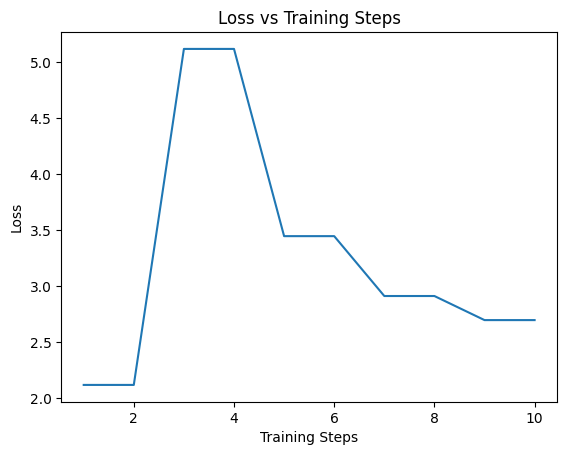

In [52]:
import matplotlib.pyplot as plt

training_steps = [i+1 for i in range(len(loss_list))]

plt.plot(training_steps, loss_list)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss vs Training Steps')
plt.show()


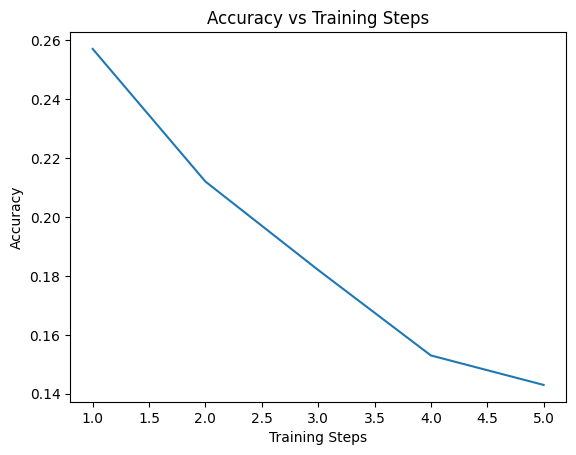

In [53]:
import matplotlib.pyplot as plt

training_steps = [i+1 for i in range(len(accuracy_list))]

plt.plot(training_steps, accuracy_list)
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Training Steps')
plt.show()


In [54]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 14.92059069378657 %


In [41]:
import torch.nn as nn

class Resnet(nn.Module):
    def __init__(self, in_channels, num_classes=7):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*7*7, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU(inplace=True)(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.ReLU(inplace=True)(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = nn.ReLU(inplace=True)(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = nn.ReLU(inplace=True)(out)
        out = self.maxpool(out)
        out = nn.Flatten()(out)
        out = self.fc1(out)
        out = self.bn5(out)
        out = nn.ReLU(inplace=True)(out)
        out = self.fc2(out)
        return out


In [42]:
#how to determine number of blocks in each layer
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])
  
model = ResNet18()

In [44]:
import torch.utils.data as data
import numpy as np

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_samples = len(train_dataset)

# Select the first 1000 samples
subset_indices = np.random.choice(num_samples, size=1000, replace=False)

# Create a subset of the training dataset 
train_subset = data.Subset(train_dataset, subset_indices)

# Create a new data loader using the subset of the dataset
train_subset_loader = data.DataLoader(dataset=train_subset,
                                      batch_size=200,
                                      shuffle=True)

num_samples2 = len(test_dataset)
subset_indices2 = np.random.choice(num_samples2, size=1000, replace=False)

# Create a subset of the testing dataset 
test_subset = data.Subset(test_dataset, subset_indices2)

# Create a new data loader using the subset of the dataset
test_subset_loader = data.DataLoader(dataset=test_subset,
                                      batch_size=200,
                                      shuffle=True)

# For updating learning rate, we are not using it because too few epochs
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

# To append loss and accuracies
loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_subset_loader):
        images = images
        labels = labels

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy on the test subset
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_subset_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            accuracy = correct / total
            accuracy_list.append(accuracy)

        # Append loss to list
        loss_list.append(loss.item())

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

print('Done with training.')


Done with training.


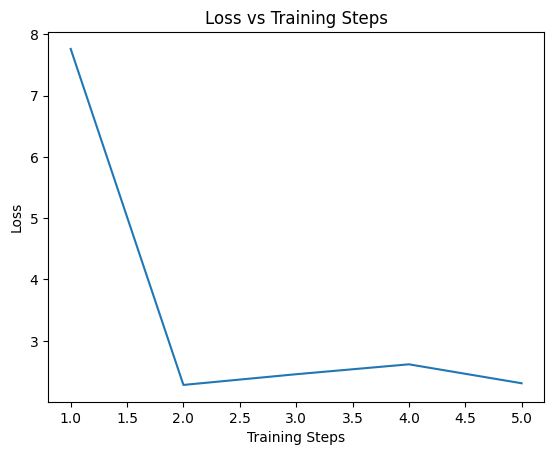

In [45]:
import matplotlib.pyplot as plt

training_steps = [i+1 for i in range(len(loss_list))]

plt.plot(training_steps, loss_list)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss vs Training Steps')
plt.show()


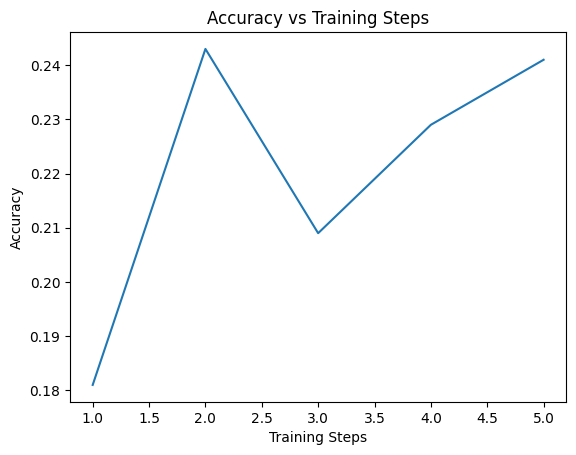

In [47]:
import matplotlib.pyplot as plt

training_steps = [i+1 for i in range(len(accuracy_list))]

plt.plot(training_steps, accuracy_list)
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Training Steps')
plt.show()


In [46]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 24.324324324324323 %
